In [1]:
import os
import sys
import pickle
import math
import time
from argparse import ArgumentParser

import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.utils as tutils
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from transformers import BertConfig
import geoopt as gt

from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import os 

import numpy as np
import pandas as pd 
from tqdm import tqdm

D:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
D:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
import re

def preprocess_for_bert(text, max_length=512):
    # Очистка текста
    text = re.sub(r'<[^>]+>|https?://\S+|www\.\S+|\S+@\S+', '', text)  # удаляем HTML, URL, email
    text = re.sub(r'[^\w\sа-яА-ЯёЁ.,!?;:()\-—"«»]', '', text)  # удаляем мусорные символы
    text = re.sub(r'\s+', ' ', text).strip()  # нормализация пробелов
    
    return text

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [73]:
def save_dataset(df_name, 
                 texts, 
                 labels, 
                 max_length=256):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # или ваша модель

    # Токенизация
    inputs = tokenizer(
        texts,
        padding="max_length",  # или "longest" для динамического паддинга
        truncation=True,
        max_length=max_length,  # Максимальная длина для BERT
        return_tensors="pt",  # Возвращать тензоры PyTorch
    )

    # Тензоры из токенизатора + метки
    dataset = TensorDataset(
        inputs["input_ids"],
        inputs["token_type_ids"],
        inputs["attention_mask"],
        th.tensor(labels, dtype=th.long),  # Метки как тензор
    )

    analyze_sequence_lengths(np.array(dataset[:][0].detach()), padding_token_id=0)
    
    th.save(dataset, os.path.join('D:\Data science\Datasets\masked_data', f"{df_name}.pt"))

In [72]:
np.array(dataset[:][0].detach())

array([[  101,  2149,  2331, ...,     0,     0,     0],
       [  101,  2057,  2097, ...,     0,     0,     0],
       [  101,  5785,  7597, ...,     0,     0,     0],
       ...,
       [  101,  1055,  8503, ...,     0,     0,     0],
       [  101, 16716,  2015, ...,     0,     0,     0],
       [  101, 13463,  2522, ...,     0,     0,     0]], dtype=int64)

# Corona virus

In [10]:
train = pd.read_csv(r'D:\my_python_projects\Probing BERT\PoincareProbe\SentimentProbe\raw\Corona_NLP_train.csv', 
           encoding='latin-1')

In [11]:
test = pd.read_csv(r'D:\my_python_projects\Probing BERT\PoincareProbe\SentimentProbe\raw\Corona_NLP_test.csv', 
           encoding='latin-1')

In [12]:
train = train[train.Sentiment != 'Neutral'].sample(n=len(test), random_state=42)
test = test[test.Sentiment != 'Neutral']

In [13]:
texts_train = train['OriginalTweet'].map(preprocess_for_bert).to_list()
texts_test = test['OriginalTweet'].map(preprocess_for_bert).to_list()

In [14]:
mapping = {
    'Extremely Negative': 0, 
    'Extremely Positive': 1, 
    'Negative': 0,
    'Positive': 1
}

In [15]:
labels_train = train['Sentiment'].map(mapping).to_list()
labels_test = test['Sentiment'].map(mapping).to_list()

In [45]:
def create_df(texts_train, labels_train, texts_test, labels_test):
    train_final = pd.DataFrame({'text': texts_train, 
                  'label': map(lambda x : 'Positive' if x == 1 else 'Negative', labels_train), 
                  'sample': ['train']*len(labels_train)})
    test_final = pd.DataFrame({'text': texts_test, 
                  'label': map(lambda x : 'Positive' if x == 1 else 'Negative', labels_test), 
                  'sample': ['test']*len(labels_test)})
    
    return pd.concat([train_final, test_final])

In [46]:
metric_df = create_df(texts_train, labels_train, texts_test, labels_test)

In [16]:
from transformers import BertTokenizer
import torch as th
from torch.utils.data import TensorDataset
import os 

In [17]:
import os 

In [18]:
print(len(labels_train), len(labels_test))

3798 3179


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def analyze_sequence_lengths(token_ids, padding_token_id=0, sample=None):
    """
    Анализирует распределение длины последовательностей токенов
    
    Параметры:
        token_ids: список списков токенов (подготовленные ID для BERT)
        padding_token_id: ID токена паддинга (по умолчанию 0)
    """
    # Вычисляем длины последовательностей без паддинга
    seq_lengths = []
    for seq in token_ids:
        # Удаляем паддинг (токены с padding_token_id)
        actual_tokens = [token for token in seq if token != padding_token_id]
        seq_lengths.append(len(actual_tokens))
    
    general_metrics = [np.mean(seq_lengths), np.median(seq_lengths), 
                       np.std(seq_lengths), np.min(seq_lengths), 
                       np.max(seq_lengths)]
    # Основные статистики
#     print(f"Средняя длина последовательности: {np.mean(seq_lengths):.1f} токенов")
#     print(f"Медианная длина: {np.median(seq_lengths):.1f} токенов")
#     print(f"Минимальная длина: {np.min(seq_lengths)} токенов")
#     print(f"Максимальная длина: {np.max(seq_lengths)} токенов")
#     print(f"Стандартное отклонение: {np.std(seq_lengths):.1f}")
    
    # Визуализация распределения
    plt.figure(figsize=(12, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(seq_lengths, bins=30)
    plt.title(f'Распределение длины последовательностей ({sample})')
    plt.xlabel('Количество токенов')
    plt.ylabel('Частота')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=seq_lengths)
    plt.title(f'Boxplot ({sample})')
    plt.xlabel('Количество токенов')
    
    plt.tight_layout()
    plt.show()
    
    return general_metrics

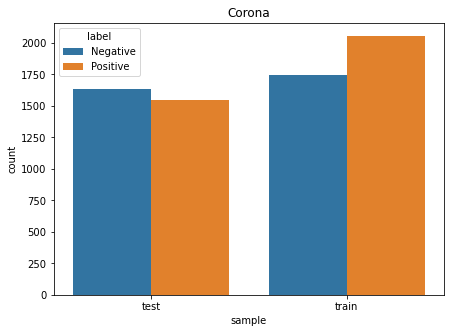

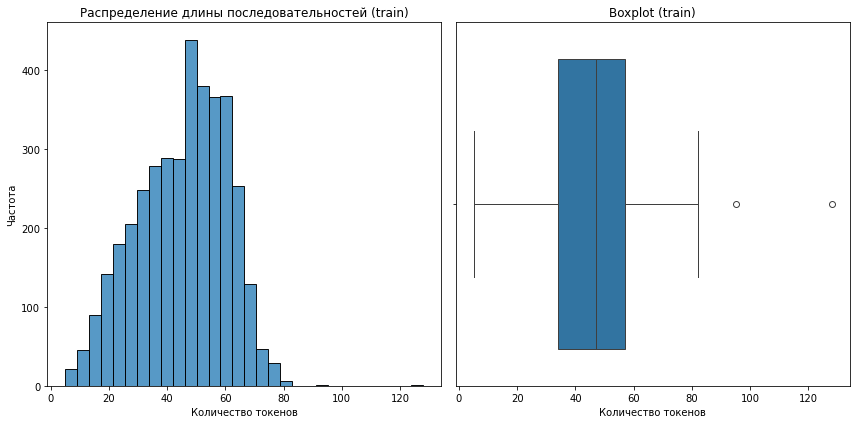

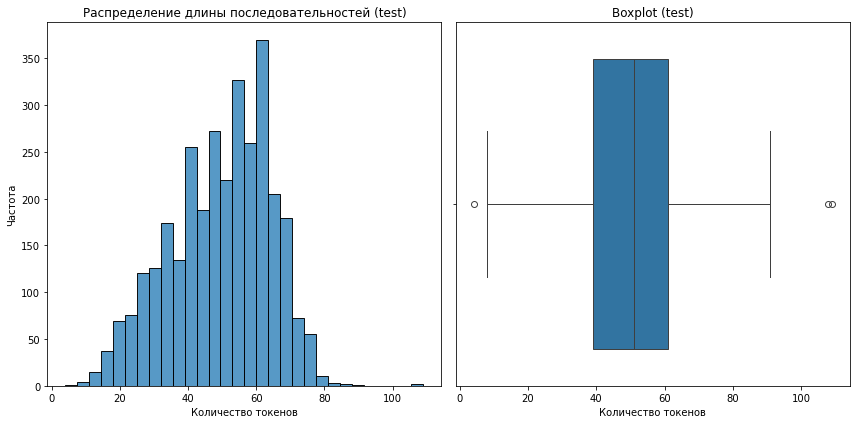

([45.17482885729331, 47.0, 15.229713011391977, 5, 128],
 [49.25511167033658, 51.0, 14.633383909455427, 4, 109])

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_metrics(df, dataset_name, max_length):
    
    group_data = df.groupby(['label', 'sample'], as_index=False).agg(count=('text', 'count'))

    plt.figure(figsize=(7, 5))
    sns.barplot(data=group_data,
                x='sample', 
                y='count',
                hue='label')
    plt.title(dataset_name)
    plt.show()
    
    inputs = tokenizer(
        df[df['sample'] == 'train']['text'].to_list(),
        padding="max_length",  # или "longest" для динамического паддинга
        truncation=True,
        max_length=max_length,  # Максимальная длина для BERT
        return_tensors="pt",  # Возвращать тензоры PyTorch
    )

    # Тензоры из токенизатора + метки
    dataset = TensorDataset(
        inputs["input_ids"],
        inputs["token_type_ids"],
        inputs["attention_mask"],
        th.tensor(labels_train, dtype=th.long),  # Метки как тензор
    )
    
    gen_metrics_train = analyze_sequence_lengths(np.array(dataset[:][0].detach()), padding_token_id=0, sample='train')
    
    inputs = tokenizer(
        df[df['sample'] == 'test']['text'].to_list(),
        padding="max_length",  # или "longest" для динамического паддинга
        truncation=True,
        max_length=max_length,  # Максимальная длина для BERT
        return_tensors="pt",  # Возвращать тензоры PyTorch
    )

    # Тензоры из токенизатора + метки
    dataset = TensorDataset(
        inputs["input_ids"],
        inputs["token_type_ids"],
        inputs["attention_mask"],
        th.tensor(labels_test, dtype=th.long),  # Метки как тензор
    )
    
    gen_metrics_test = analyze_sequence_lengths(np.array(dataset[:][0].detach()), padding_token_id=0, sample='test')
    
    return (gen_metrics_train, gen_metrics_test)

show_metrics(metric_df, 'Corona', max_length=128)

Средняя длина последовательности: 45.2 токенов
Медианная длина: 47.0 токенов
Минимальная длина: 5 токенов
Максимальная длина: 128 токенов
Стандартное отклонение: 15.2


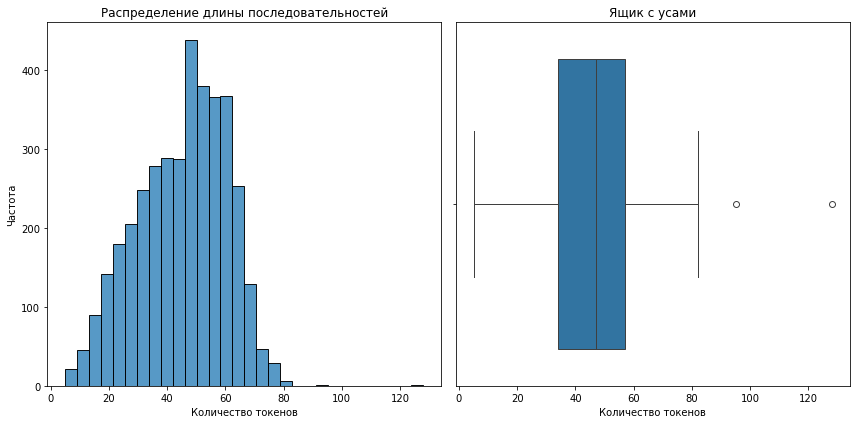


Частоты встречаемости длин:
5 токенов: 2 примеров (0.1%)
7 токенов: 1 примеров (0.0%)
8 токенов: 10 примеров (0.3%)
9 токенов: 8 примеров (0.2%)
10 токенов: 9 примеров (0.2%)
11 токенов: 13 примеров (0.3%)
12 токенов: 7 примеров (0.2%)
13 токенов: 16 примеров (0.4%)
14 токенов: 20 примеров (0.5%)
15 токенов: 22 примеров (0.6%)
16 токенов: 27 примеров (0.7%)
17 токенов: 20 примеров (0.5%)
18 токенов: 30 примеров (0.8%)
19 токенов: 39 примеров (1.0%)
20 токенов: 38 примеров (1.0%)
21 токенов: 34 примеров (0.9%)
22 токенов: 38 примеров (1.0%)
23 токенов: 49 примеров (1.3%)
24 токенов: 44 примеров (1.2%)
25 токенов: 49 примеров (1.3%)
26 токенов: 50 примеров (1.3%)
27 токенов: 56 примеров (1.5%)
28 токенов: 43 примеров (1.1%)
29 токенов: 56 примеров (1.5%)
30 токенов: 66 примеров (1.7%)
31 токенов: 63 примеров (1.7%)
32 токенов: 46 примеров (1.2%)
33 токенов: 73 примеров (1.9%)
34 токенов: 53 примеров (1.4%)
35 токенов: 79 примеров (2.1%)
36 токенов: 65 примеров (1.7%)
37 токенов: 81 прим

In [99]:
save_dataset('train_dataset', 
                 texts_train, 
                 labels_train, 
                 max_length=128)

Средняя длина последовательности: 49.3 токенов
Медианная длина: 51.0 токенов
Минимальная длина: 4 токенов
Максимальная длина: 109 токенов
Стандартное отклонение: 14.6


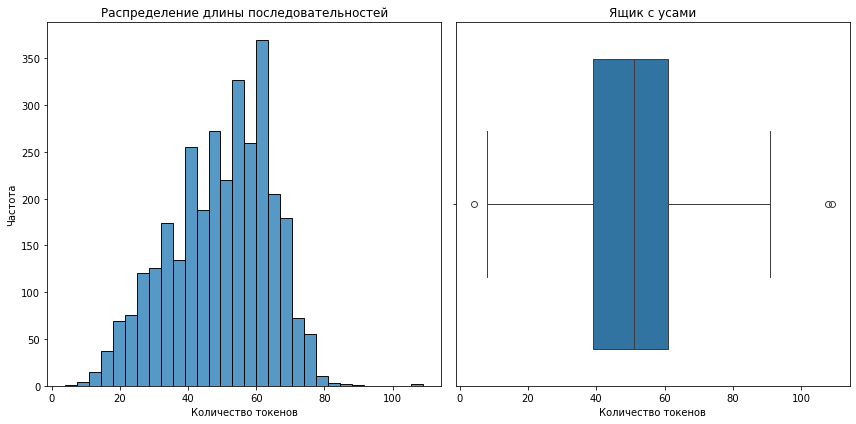


Частоты встречаемости длин:
4 токенов: 1 примеров (0.0%)
8 токенов: 2 примеров (0.1%)
9 токенов: 1 примеров (0.0%)
10 токенов: 1 примеров (0.0%)
11 токенов: 2 примеров (0.1%)
12 токенов: 2 примеров (0.1%)
13 токенов: 6 примеров (0.2%)
14 токенов: 5 примеров (0.2%)
15 токенов: 9 примеров (0.3%)
16 токенов: 16 примеров (0.5%)
17 токенов: 12 примеров (0.4%)
18 токенов: 10 примеров (0.3%)
19 токенов: 21 примеров (0.7%)
20 токенов: 15 примеров (0.5%)
21 токенов: 23 примеров (0.7%)
22 токенов: 27 примеров (0.8%)
23 токенов: 23 примеров (0.7%)
24 токенов: 26 примеров (0.8%)
25 токенов: 20 примеров (0.6%)
26 токенов: 37 примеров (1.2%)
27 токенов: 31 примеров (1.0%)
28 токенов: 33 примеров (1.0%)
29 токенов: 42 примеров (1.3%)
30 токенов: 37 примеров (1.2%)
31 токенов: 47 примеров (1.5%)
32 токенов: 38 примеров (1.2%)
33 токенов: 48 примеров (1.5%)
34 токенов: 47 примеров (1.5%)
35 токенов: 41 примеров (1.3%)
36 токенов: 48 примеров (1.5%)
37 токенов: 52 примеров (1.6%)
38 токенов: 34 примеро

In [100]:
save_dataset('test_dataset', 
                 texts_test, 
                 labels_test, 
                 max_length=128)

# Tweet sentiment

In [209]:
train = pd.read_csv(r'D:\Data science\Datasets\twitter_training.csv', 
           encoding='latin-1', header=None).rename(columns={0: 'code', 
                                                            1: 'hui', 
                                                            2: 'Sentiment', 
                                                            3: 'OriginalTweet', 
                                                            })

In [210]:
test = pd.read_csv(r'D:\Data science\Datasets\twitter_validation.csv', 
           encoding='latin-1', header=None).rename(columns={0: 'code', 
                                                            1: 'hui', 
                                                            2: 'Sentiment', 
                                                            3: 'OriginalTweet', 
                                                            })

In [211]:
dop_test = train[train.Sentiment.isin(['Positive', 'Negative'])][~train['OriginalTweet'].isna()].iloc[-3000:]
train = train[train.Sentiment.isin(['Positive', 'Negative'])][~train['OriginalTweet'].isna()].iloc[:-3000].sample(n=3543, 
                                                                                                                  random_state=42)
test = test[test.Sentiment.isin(['Positive', 'Negative'])][~test['OriginalTweet'].isna()]
test = pd.concat([test, dop_test])

C:\Users\PC\AppData\Local\Temp\ipykernel_14264\1416843924.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dop_test = train[train.Sentiment.isin(['Positive', 'Negative'])][~train['OriginalTweet'].isna()].iloc[-3000:]
C:\Users\PC\AppData\Local\Temp\ipykernel_14264\1416843924.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = train[train.Sentiment.isin(['Positive', 'Negative'])][~train['OriginalTweet'].isna()].iloc[:-3000].sample(n=3543,
C:\Users\PC\AppData\Local\Temp\ipykernel_14264\1416843924.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test = test[test.Sentiment.isin(['Positive', 'Negative'])][~test['OriginalTweet'].isna()]


In [212]:
texts_train = train['OriginalTweet'].map(preprocess_for_bert).to_list()
texts_test = test['OriginalTweet'].map(preprocess_for_bert).to_list()

In [213]:
mapping = {
    'Extremely Negative': 0, 
    'Extremely Positive': 1, 
    'Negative': 0,
    'Positive': 1
}

In [214]:
labels_train = train['Sentiment'].map(mapping).to_list()
labels_test = test['Sentiment'].map(mapping).to_list()

In [215]:
print(len(labels_train), len(labels_test))

3543 3543


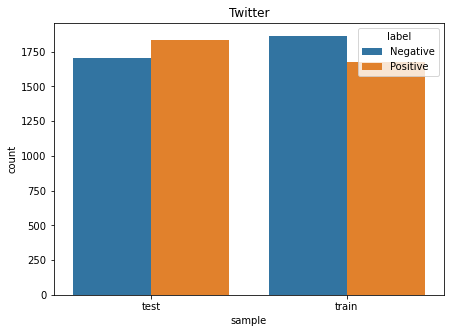

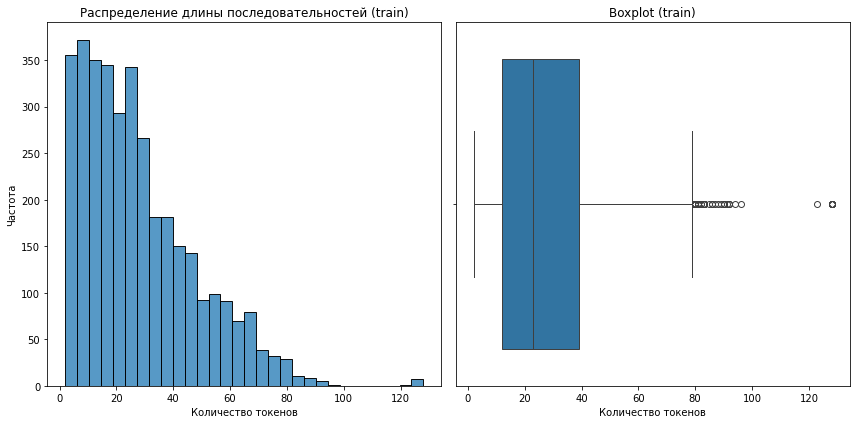

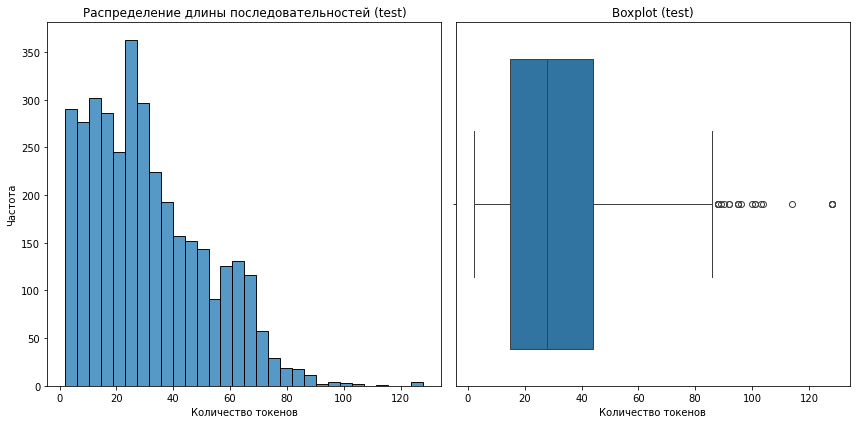

([27.75952582557155, 23.0, 19.683102696315636, 2, 128],
 [31.19023426474739, 28.0, 20.391357146148973, 2, 128])

In [216]:
metric_df = create_df(texts_train, labels_train, texts_test, labels_test)
show_metrics(metric_df, 'Twitter', max_length=128)

In [71]:
save_dataset('Train_twtter', 
                 texts_train, 
                 labels_train, 
                 max_length=256)

In [72]:
save_dataset('Test_twtter', 
                 texts_test, 
                 labels_test, 
                 max_length=256)

In [73]:
inputs = tokenizer(
    texts_train,
    padding="max_length",  # или "longest" для динамического паддинга
    truncation=True,
    max_length=256,  # Максимальная длина для BERT
    return_tensors="pt",  # Возвращать тензоры PyTorch
)

In [74]:
inputs['input_ids'].shape

torch.Size([3543, 256])

# Financial sentiment

In [222]:
data = pd.read_csv(r'D:\Data science\Datasets\data.csv', 
           encoding='latin-1')

In [223]:
data

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [224]:
data = data[data.Sentiment.isin(['positive', 'negative'])][~data['Sentence'].isna()]

C:\Users\PC\AppData\Local\Temp\ipykernel_14264\3986300818.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[data.Sentiment.isin(['positive', 'negative'])][~data['Sentence'].isna()]


In [225]:
train, test = train_test_split(data, test_size=0.35, random_state=42)

In [226]:
texts_train = train['Sentence'].map(preprocess_for_bert).to_list()
texts_test = test['Sentence'].map(preprocess_for_bert).to_list()

In [227]:
mapping = {
    'negative': 0,
    'positive': 1
}

In [228]:
labels_train = train['Sentiment'].map(mapping).to_list()
labels_test = test['Sentiment'].map(mapping).to_list()

In [229]:
print(len(labels_train), len(labels_test))

1762 950


In [241]:
list(zip(texts_test, labels_test))

[('The company s net profit rose 11.4 on the year to 82.2 million euros in 2005 on sales of 686.5 million euros , 13.8 up on the year , the company said earlier .',
  1),
 ('Passenger volumes rose by 8.4 in the accounting period .', 1),
 ('Componenta increased its stake in Turkish steel company Doktas Dokumculuk Ticaret ve Sanayi A.S. to 92.6 pct stake in March 2007 .',
  1),
 ('While concerns remain longer term , size and scale may enable Nokia to hold on to its newfound margin improvements in the near term , the analyst wrote .',
  1),
 ('UPDATE 3-Stifel to buy former Lehman brokerage from Barclays', 1),
 ('Eli Lilly Co. (LLY) Has Broken Out To A New High On AstraZeneca Collaboration',
  1),
 ('Is It Worth Investing In Tesco PLC And Prudential plc Now?', 1),
 ('15 December 2010 - Finnish-German telecoms equipment maker Nokia Siemens Networks said today it won a contract to upgrade the radio network of home-based telecommunications company Elisa Oyj HEL : ELI1V .',
  1),
 ('We are ver

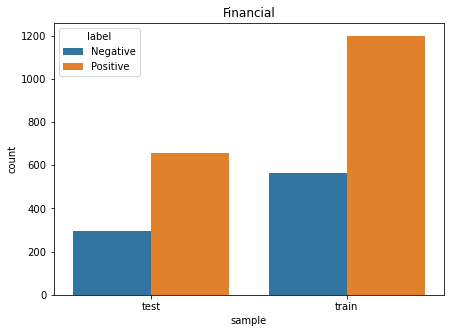

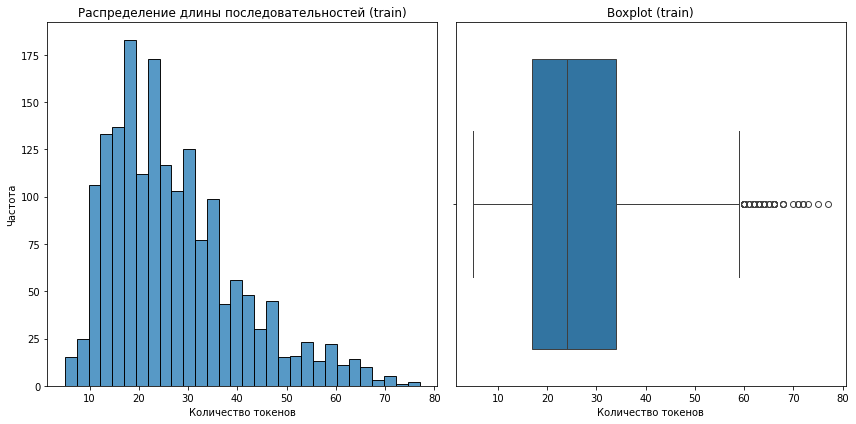

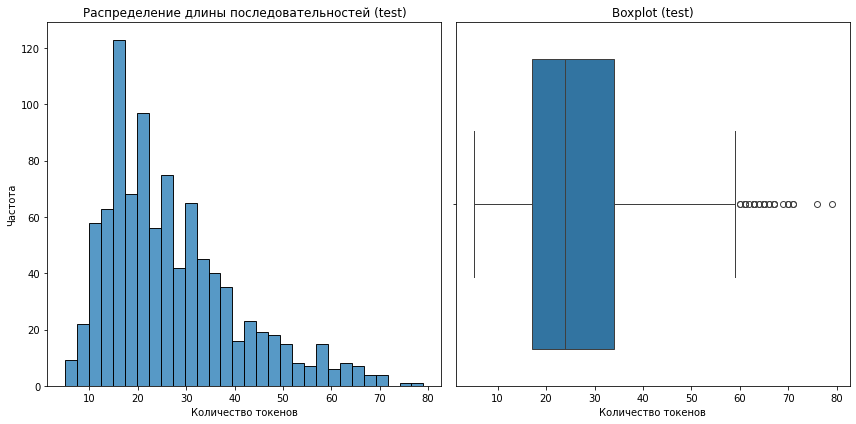

([27.07377979568672, 24.0, 13.146869836873574, 5, 77],
 [26.961052631578948, 24.0, 13.599750730972914, 5, 79])

In [242]:
metric_df = create_df(texts_train, labels_train, texts_test, labels_test)
show_metrics(metric_df, 'Financial', max_length=100)

In [245]:
metric_df.to_csv('finance_dataset.csv')

In [84]:
save_dataset('Train_financial', 
                 texts_train, 
                 labels_train, 
                 max_length=100)

In [85]:
save_dataset('Test_financial', 
                 texts_test, 
                 labels_test, 
                 max_length=100)

In [86]:
inputs = tokenizer(
    texts_train,
    padding="longest",  # или "longest" для динамического паддинга
    truncation=True,
    return_tensors="pt",  # Возвращать тензоры PyTorch
)

In [87]:
inputs['input_ids'].shape

torch.Size([1762, 77])

# sentiment

In [192]:
train = pd.read_csv(r'D:\Data science\Datasets\train_sentiment.csv', 
           encoding='latin-1')

In [193]:
test = pd.read_csv(r'D:\Data science\Datasets\test_sentiment.csv', 
           encoding='latin-1')

In [194]:
train = train[train.sentiment.isin(['positive', 'negative'])][~train['text'].isna()].sample(n=3000, random_state=42)
test = test[test.sentiment.isin(['positive', 'negative'])][~test['text'].isna()]

C:\Users\PC\AppData\Local\Temp\ipykernel_14264\2784282194.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = train[train.sentiment.isin(['positive', 'negative'])][~train['text'].isna()].sample(n=3000, random_state=42)
C:\Users\PC\AppData\Local\Temp\ipykernel_14264\2784282194.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test = test[test.sentiment.isin(['positive', 'negative'])][~test['text'].isna()]


In [195]:
texts_train = train['text'].map(preprocess_for_bert).to_list()
texts_test = test['text'].map(preprocess_for_bert).to_list()

In [196]:
mapping = {
    'negative': 0,
    'positive': 1
}

In [197]:
labels_train = train['sentiment'].map(mapping).to_list()
labels_test = test['sentiment'].map(mapping).to_list()

In [198]:
print(len(labels_train), len(labels_test))

3000 2104


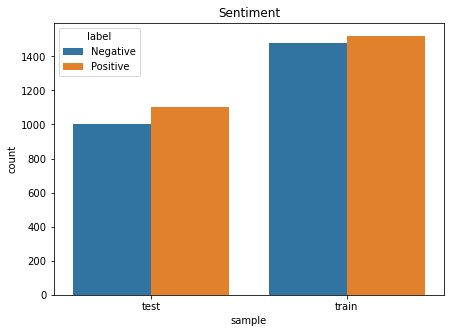

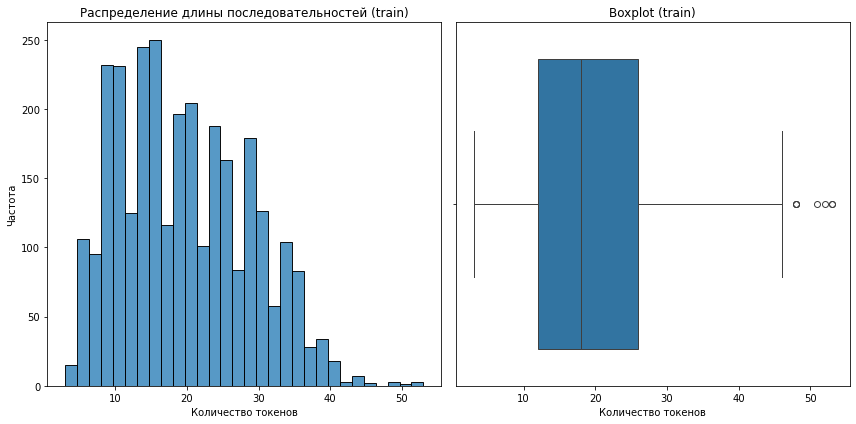

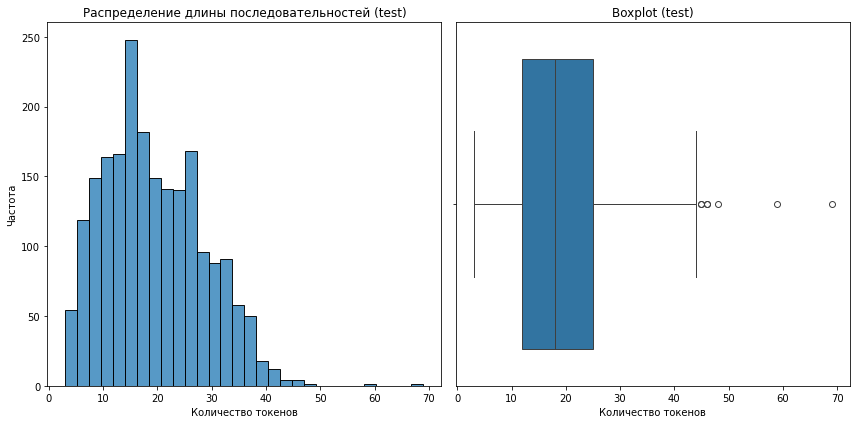

([19.472333333333335, 18.0, 9.015240866936884, 3, 53],
 [19.247148288973385, 18.0, 9.023245300116317, 3, 69])

In [199]:
metric_df = create_df(texts_train, labels_train, texts_test, labels_test)
show_metrics(metric_df, 'Sentiment', max_length=100)

In [101]:
save_dataset('Train_sentiment', 
                 texts_train, 
                 labels_train, 
                 max_length=100)

In [102]:
save_dataset('Test_sentiment', 
                 texts_test, 
                 labels_test, 
                 max_length=100)

In [103]:
inputs = tokenizer(
    texts_train,
    padding="longest",  # или "longest" для динамического паддинга
    truncation=True,
    return_tensors="pt",  # Возвращать тензоры PyTorch
)

In [104]:
inputs['input_ids'].shape

torch.Size([3000, 53])

# Mental sentiment

In [200]:
data = pd.read_csv(r'D:\Data science\Datasets\Mental_health_data.csv', 
           encoding='latin-1')

In [201]:
data.status.value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [202]:
data = data[data.status.isin(['Normal', 'Depression'])][~data['statement'].isna()].sample(n=8000, 
                                                                                         random_state=42)

C:\Users\PC\AppData\Local\Temp\ipykernel_14264\4170739778.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[data.status.isin(['Normal', 'Depression'])][~data['statement'].isna()].sample(n=8000,


In [203]:
train, test = train_test_split(data, test_size=0.375, random_state=42)

In [204]:
texts_train = train['statement'].map(preprocess_for_bert).to_list()
texts_test = test['statement'].map(preprocess_for_bert).to_list()

In [205]:
mapping = {
    'Depression': 0,
    'Normal': 1
}

In [206]:
labels_train = train['status'].map(mapping).to_list()
labels_test = test['status'].map(mapping).to_list()

In [207]:
print(len(labels_train), len(labels_test))

5000 3000


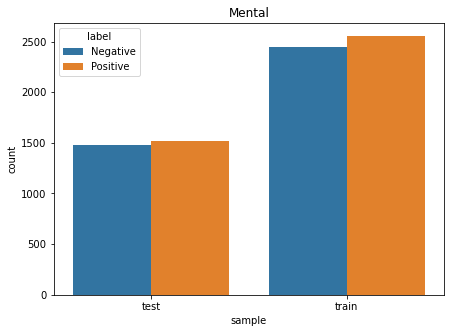

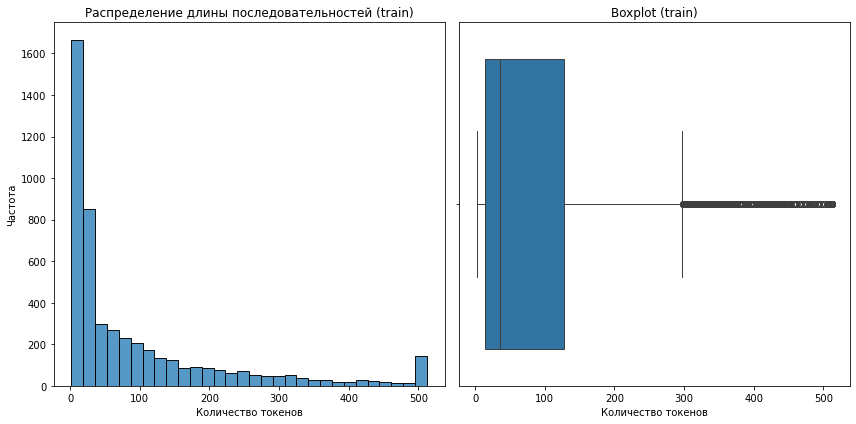

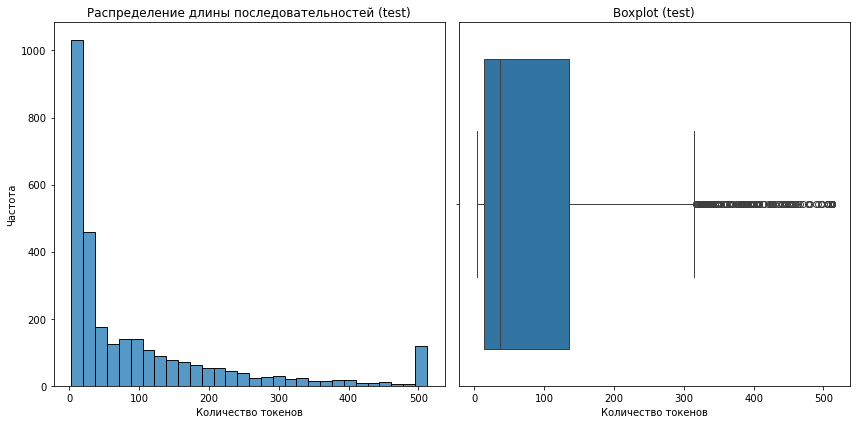

([95.8766, 35.0, 124.52241795130706, 2, 512],
 [99.50066666666666, 37.0, 128.12828987472759, 3, 512])

In [208]:
metric_df = create_df(texts_train, labels_train, texts_test, labels_test)
show_metrics(metric_df, 'Mental', max_length=512)

In [122]:
save_dataset('Train_mental', 
                 texts_train, 
                 labels_train, 
                 max_length=512)

In [123]:
save_dataset('Test_mental', 
                 texts_test, 
                 labels_test, 
                 max_length=512)

In [124]:
inputs = tokenizer(
    texts_train,
    padding="longest",  # или "longest" для динамического паддинга
    truncation=True,
    return_tensors="pt",  # Возвращать тензоры PyTorch
)

In [125]:
import matplotlib.pyplot as plt

In [126]:
import seaborn as sns

In [127]:
x_np = (inputs['input_ids'] > 0).sum(dim=1).numpy()
# x = th.randn(1000)  # 1000 значений из нормального распределения

# # Конвертируем в NumPy для визуализации
# x_np = x.numpy()

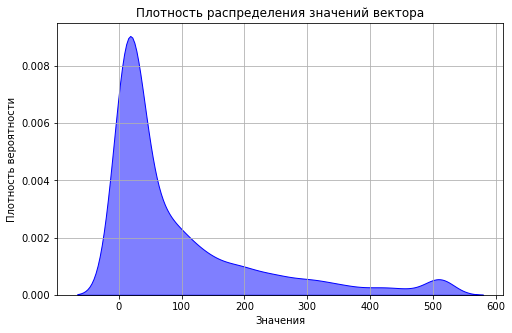

In [128]:
plt.figure(figsize=(8, 5))
sns.kdeplot(x_np, fill=True, color='blue', alpha=0.5)
plt.title('Плотность распределения значений вектора')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.grid(True)
plt.show()

In [129]:
(x_np > 511).sum()

136

# Amazon sentiment

In [162]:
def process_data(file):
    data = []
    for index, row in file.iterrows():
         # first line data is raw data
        line = row[0]
        
        #split lines into text and labels
        label, text = line.split(' ', 1) 
        
        #remove the __label__ only keep the number
        label = label.replace('__label__', '') 
        
        #append
        data.append((label, text.strip()))
        
    cols = ['label', 'review']
    return pd.DataFrame(data, columns=cols)


In [163]:
import re

In [164]:
def text_cleaning(text):
    
    #apply lowercase
    text = text.lower()  
    
    #remove special characters and numbers and extra whitespace
    pattern_punc = r'[^A-Za-z\s]'
    text = re.sub(pattern_punc, '', text).strip()
    return text

In [165]:
train_path = r'D:\Data science\Datasets\train.ft.txt.bz2'
test_path = r'D:\Data science\Datasets\test.ft.txt.bz2'

In [166]:
train_data = pd.read_csv(train_path, compression='bz2', delimiter='\t')
test_data = pd.read_csv(test_path, compression='bz2', delimiter='\t')

In [167]:
train = process_data(train_data.sample(n=5000, random_state=42))
test = process_data(test_data.sample(n=3000, random_state=42))

C:\Users\PC\AppData\Local\Temp\ipykernel_14264\1577481634.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  line = row[0]


In [168]:
# train = train.sample(n=100000, random_state=42)
# test = test.sample(n=20000, random_state=42)

In [169]:
train['label'] = train['label'].replace({"2":1, "1":0}) #train data
test['label'] = test['label'].replace({"2":1, "1":0}) #test data

C:\Users\PC\AppData\Local\Temp\ipykernel_14264\1172928791.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['label'] = train['label'].replace({"2":1, "1":0}) #train data
C:\Users\PC\AppData\Local\Temp\ipykernel_14264\1172928791.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['label'] = test['label'].replace({"2":1, "1":0}) #test data


In [170]:
print("Count of labels in the train data is:" ,train['label'].value_counts())
print("-"*45)
print("Count of labels in the test data is:" ,test['label'].value_counts())

Count of labels in the train data is: label
0    2529
1    2471
Name: count, dtype: int64
---------------------------------------------
Count of labels in the test data is: label
1    1518
0    1482
Name: count, dtype: int64


In [171]:
train['text'] = train['review'].map(preprocess_for_bert)
test['text'] = test['review'].map(preprocess_for_bert)


In [172]:
texts_train = train['text'].to_list()
texts_test = test['text'].to_list()

In [173]:
labels_train = train['label'].to_list()
labels_test = test['label'].to_list()

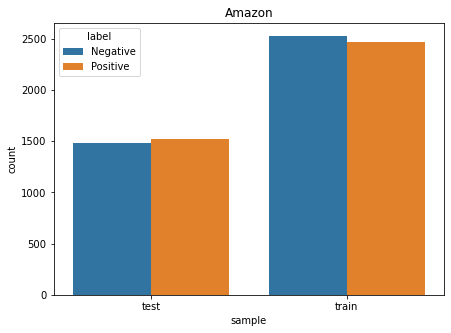

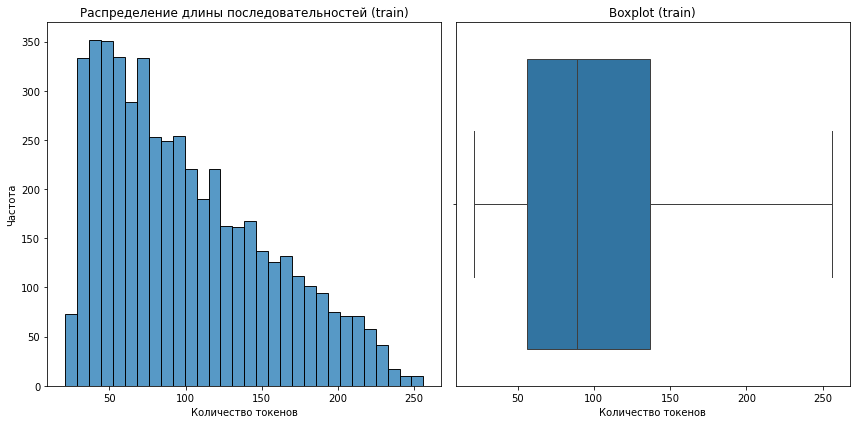

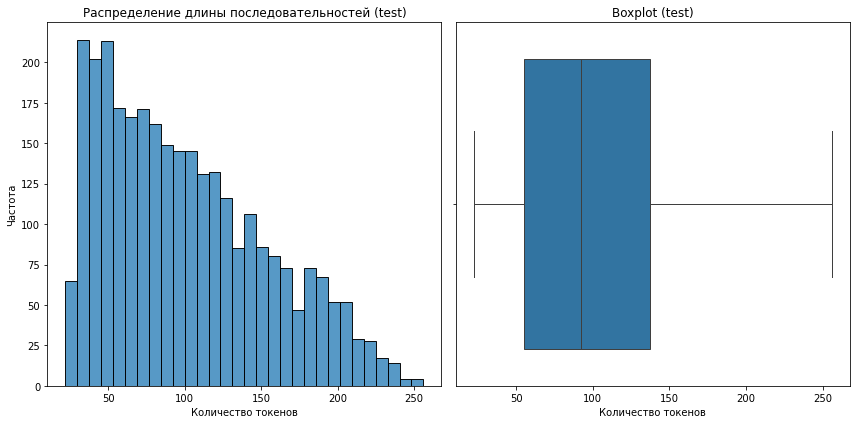

([100.2618, 89.0, 53.41832701199093, 21, 256],
 [100.645, 92.0, 52.77146616938615, 22, 256])

In [174]:
metric_df = create_df(texts_train, labels_train, texts_test, labels_test)
show_metrics(metric_df, 'Amazon', max_length=256)

In [141]:
save_dataset('Train_amazon', 
                 texts_train, 
                 labels_train, 
                 max_length=256)

In [142]:
save_dataset('Test_amazon', 
                 texts_test, 
                 labels_test, 
                 max_length=256)

In [143]:
inputs = tokenizer(
    texts_train,
    padding="longest",  # или "longest" для динамического паддинга
    truncation=True,
    return_tensors="pt",  # Возвращать тензоры PyTorch
)

In [144]:
import matplotlib.pyplot as plt

In [145]:
import seaborn as sns

In [37]:
x_np = (inputs['input_ids'] > 0).sum(dim=1).numpy()
# x = th.randn(1000)  # 1000 значений из нормального распределения

# # Конвертируем в NumPy для визуализации
# x_np = x.numpy()

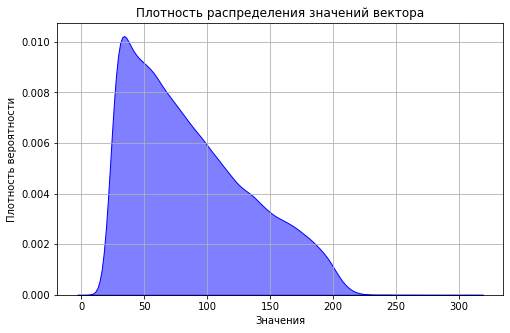

In [38]:
plt.figure(figsize=(8, 5))
sns.kdeplot(x_np, fill=True, color='blue', alpha=0.5)
plt.title('Плотность распределения значений вектора')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.grid(True)
plt.show()

In [218]:
data_stats = {
    "corona": {
        "train": [45.17482885729331, 47.0, 15.229713011391977, 5, 128],
        "test": [49.25511167033658, 51.0, 14.633383909455427, 4, 109]
    },
    "twitter": {
        "train": [27.75952582557155, 23.0, 19.683102696315636, 2, 128],
        "test": [31.19023426474739, 28.0, 20.391357146148973, 2, 128]
    },
    "Financial": {
        "train": [27.07377979568672, 24.0, 13.146869836873574, 5, 77],
        "test": [26.961052631578948, 24.0, 13.599750730972914, 5, 79]
    },
    "Sentiment": {
        "train": [19.472333333333335, 18.0, 9.015240866936884, 3, 53],
        "test": [19.247148288973385, 18.0, 9.023245300116317, 3, 69]
    },
    "Mental": {
        "train": [95.8766, 35.0, 124.52241795130706, 2, 512],
        "test": [99.50066666666666, 37.0, 128.12828987472759, 3, 512]
    },
    "Amazon": {
        "train": [100.2618, 89.0, 53.41832701199093, 21, 256],
        "test": [100.645, 92.0, 52.77146616938615, 22, 256]
    }
}

In [221]:
df = pd.DataFrame.from_dict({(i,j): data_stats[i][j] 
                           for i in data_stats.keys() 
                           for j in data_stats[i].keys()},
                       orient='index')

# Переименовываем столбцы
df.columns = ['Mean', 'Median', 'Std', 'Min', 'Max']

df.to_excel('dataset_metrics.xlsx')

C:\Users\PC\AppData\Local\Temp\ipykernel_14264\568727884.py:9: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  df.to_excel('dataset_metrics.xlsx')


In [ ]:
corona train - [45.17482885729331, 47.0, 15.229713011391977, 5, 128],
        test - [49.25511167033658, 51.0, 14.633383909455427, 4, 109]

twitter train - [27.75952582557155, 23.0, 19.683102696315636, 2, 128],
        test - [31.19023426474739, 28.0, 20.391357146148973, 2, 128]

Financial train - [27.07377979568672, 24.0, 13.146869836873574, 5, 77],
          test - [26.961052631578948, 24.0, 13.599750730972914, 5, 79]

Sentiment train - [19.472333333333335, 18.0, 9.015240866936884, 3, 53],
          test - [19.247148288973385, 18.0, 9.023245300116317, 3, 69]

Mental  train - [95.8766, 35.0, 124.52241795130706, 2, 512],
        test - [99.50066666666666, 37.0, 128.12828987472759, 3, 512]

Amazon  train - [100.2618, 89.0, 53.41832701199093, 21, 256],
        test - [100.645, 92.0, 52.77146616938615, 22, 256]